In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import os
import time

from PIL import Image

import umap
import pickle
from math import *
import random

DEVICE = "cuda"

def tovar(x):
    return torch.FloatTensor(x).to(DEVICE)

In [2]:
class Node():
    def __init__(self, k, depth, p_term, p_count, maxdepth=3):
        super().__init__()
        
        self.variable = np.random.randint(k+1)
        if self.variable == 0:
            self.threshold = np.random.randint(k)
        else:
            self.threshold = np.random.choice(np.arange(9), p=p_count)
            
        self.operation = np.random.randint(2) # Equality, >=
        
        if depth == maxdepth:
            self.children = [np.random.randint(k), np.random.randint(k)]
        else:            
            self.children = []
            for i in range(2):
                if np.random.rand()<p_term:
                    self.children.append(np.random.randint(k))
                else:
                    self.children.append(Node(k,depth+1,p_term,p_count,maxdepth))
            
    def forward(self, x):
        if self.operation == 0:
            if x[self.variable] == self.threshold:
                branch = 1
            else:
                branch = 0
        elif self.operation == 1:
            if x[self.variable] >= self.threshold:
                branch = 1
            else:
                branch = 0
        
        child = self.children[branch]
        
        if isinstance(child, Node):
            return child.forward(x)
        else:
            return child

        
class Totalistic():
    def __init__(self, colors):
        self.colors = colors
        
        rule = random.randrange(colors**(9*(colors-1)+1))
        #np.random.randint(colors**(9*(colors-1)+1), dtype=np.int64)        
        self.rule = rule
        
        transitions = np.zeros(9*(colors-1)+1)
        mult = 1
        
        for i in range(9*(colors-1)+1):
            transitions[i] = (rule//mult)%self.colors
            mult *= self.colors
        # Totalistic:
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
    
    def step(self, state):
        XR = state.shape[0]
        YR = state.shape[1]
        
        self.state = torch.LongTensor(state).to(DEVICE)
        idx = torch.arange(XR*YR).long().to(DEVICE)

        padstate = torch.cat([self.state[-1:,:], self.state, self.state[:1,:]], 0)
        padstate = torch.cat([padstate[:,-1:], padstate, padstate[:,:1]], 1)

        multiplier = self.colors
        histogram = self.state.view(XR*YR)

        shiftstate = padstate[:-2,1:-1].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[2:,1:-1].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[1:-1,:-2].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[1:-1,2:].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[:-2,:-2].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[:-2,2:].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[2:,:-2].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]
        shiftstate = padstate[2:,2:].contiguous().view(XR*YR)
        histogram[idx] += shiftstate[idx]

        result = self.transitions[histogram].view(XR, YR)
        
        return result.cpu().detach().numpy()

class FourNeighbor():
    def __init__(self, colors):
        self.colors = colors
        
        # 4 neighbor outer symmetric
        # 
        # k (center) * 5^k (outer [0,1,2,3,4] for each color)
        self.transitions = torch.LongTensor(np.random.randint(colors, size=(colors * 5**colors))).to(DEVICE)

    def tree_transition(self, depth=3, counts=5):
        proba = np.zeros(9)
        proba[:counts] = 1
        proba = proba/np.sum(proba)
        
        tree = Node(self.colors, 1, 0.0, proba, depth)
        
        transitions = np.zeros((self.colors * 5**self.colors))
        
        for i in range(self.colors * 5**self.colors):
            idx = np.zeros((1+self.colors,)).astype(np.int32)
            
            mult = 1
            idx[0] = (i//mult)%self.colors
            mult *= self.colors
            for k in range(self.colors):
                idx[k+1] = (i//mult)%5
                mult *= 5
            
            transitions[i] = tree.forward(idx)
        
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
        
    def step(self, state):
        XR = state.shape[0]
        YR = state.shape[1]
        
        self.state = torch.LongTensor(state).to(DEVICE)
        idx = torch.arange(XR*YR).long().to(DEVICE)

        padstate = torch.cat([self.state[-1:,:], self.state, self.state[:1,:]], 0)
        padstate = torch.cat([padstate[:,-1:], padstate, padstate[:,:1]], 1)

        multiplier = int(self.colors)
        indices = self.state.view(XR*YR).long()

        histogram = torch.zeros((XR*YR, self.colors)).long().to(DEVICE)

        shiftstate = padstate[:-2,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1

        for k in range(self.colors):
            indices += multiplier * histogram[:,k] 
            multiplier *= 5

        result = self.transitions[indices].view(XR, YR)
        
        return result.cpu().detach().numpy()

class EightNeighbor():
    def __init__(self, colors):
        self.colors = colors
        
        # 8 neighbor outer symmetric
        # 
        # k (center) * 9^k (outer [0,...,8] for each color)
        self.transitions = torch.LongTensor(np.random.randint(colors, size=(colors * 9**colors))).to(DEVICE)
    
    def tree_transition(self, depth=3, counts=9):
        proba = np.zeros(9)
        proba[:counts] = 1
        proba = proba/np.sum(proba)
        
        tree = Node(self.colors, 1, 0.0, proba, depth)
        
        transitions = np.zeros((self.colors * 9**self.colors))
        
        for i in range(self.colors * 9**self.colors):
            idx = np.zeros((1+self.colors,)).astype(np.int32)
            
            mult = 1
            idx[0] = (i//mult)%self.colors
            mult *= self.colors
            for k in range(self.colors):
                idx[k+1] = (i//mult)%9
                mult *= 9
            
            transitions[i] = tree.forward(idx)
        
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
        
    def tree_transition2(self, depth, p_term, p_count):
        tree = Node(self.colors, 1, p_term, p_count, maxdepth=depth)
        transitions = np.zeros((self.colors * 9**self.colors))
        
        for i in range(self.colors * 9**self.colors):
            idx = np.zeros((1+self.colors,)).astype(np.int32)
            
            mult = 1
            idx[0] = (i//mult)%self.colors
            mult *= self.colors
            for k in range(self.colors):
                idx[k+1] = (i//mult)%9
                mult *= 9
            
            transitions[i] = tree.forward(idx)
        
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
        
    def step(self, state):
        XR = state.shape[0]
        YR = state.shape[1]
        
        self.state = torch.LongTensor(state).to(DEVICE)
        idx = torch.arange(XR*YR).long().to(DEVICE)

        padstate = torch.cat([self.state[-1:,:], self.state, self.state[:1,:]], 0)
        padstate = torch.cat([padstate[:,-1:], padstate, padstate[:,:1]], 1)

        multiplier = int(self.colors)
        indices = self.state.view(XR*YR).long()

        histogram = torch.zeros((XR*YR, self.colors)).long().to(DEVICE)

        shiftstate = padstate[:-2,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,1:-1].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[1:-1,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
            
        shiftstate = padstate[:-2,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[:-2,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,:-2].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1
        shiftstate = padstate[2:,2:].contiguous().view(XR*YR)
        histogram[idx, shiftstate[idx]] += 1

        for k in range(self.colors):
            indices += multiplier * histogram[:,k] 
            multiplier *= 9

        result = self.transitions[indices].view(XR, YR)
        
        return result.cpu().detach().numpy()

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv3d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm3d(32)
        self.l1b = nn.Conv3d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm3d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool3d(2)
        
        self.l2a = nn.Conv3d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv3d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool3d(2)

        self.l3a = nn.Conv3d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv3d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool3d(2)
        
        self.l4a = nn.Conv3d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv3d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool3d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(4).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z
    
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca_2d_multitype2.pth"))
net.eval()

clf = pickle.load(open("umap_classifier_multi_4.pkl","rb"))

In [4]:
def totensor(history, rgb):
    XR = history.shape[1]
    YR = history.shape[0]
    TR = history.shape[2]
    
    hist = history.transpose(1,0,2).reshape((XR*YR*TR))
    
    im = 2*rgb[hist]-0.5
    im = im.transpose(1,0).reshape((1,3,XR,YR,TR))
    return tovar(im)

def render(history,rgb):    
    XR = history.shape[1]
    YR = history.shape[0]
    
    hist = history.transpose(1,0).reshape((XR*YR))
    im = np.clip(256*rgb[hist],0,255).astype(np.uint8)
    im = im.reshape((XR,YR,3))
    im = Image.fromarray(im)
    return im

def generate_palette(k):
    stop = False
    
    while not stop:
        rgb = np.random.rand(k,3)
        dist = np.sum(np.abs(rgb[np.newaxis,:,:] - rgb[:,np.newaxis,:]),axis=2)
        dist[np.arange(k), np.arange(k)] += 10
        mindist = np.min(dist)
        if mindist > 0.75:
            stop = True
    
    return rgb

In [5]:
from IPython import display
import time

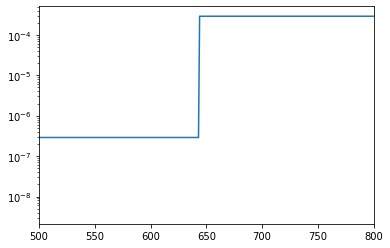

In [10]:
count = np.sum(rawdensity)
q = rawdensity/count
p = 1.0/q
p = p/np.sum(p)        
sp = np.sort(p.ravel())

plt.plot(sp)
plt.xlim(500,800)
plt.yscale("log")
plt.show()

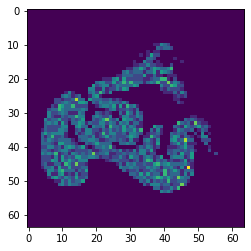

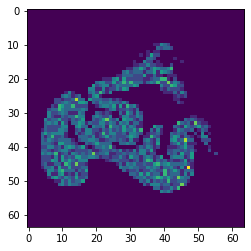

In [12]:
# Make random CAs

UMIN = -24
UMAX = 24
VMIN = -24
VMAX = 24
BINS = 64

k = 4
basergb = generate_palette(k)

#density = np.zeros((BINS,BINS))+1e-3
#rawdensity = np.zeros((BINS,BINS))+1e-3

for i in range(758,3000):
    ca = EightNeighbor(k)

    # Sample with p such that p*q = 1
    # So p ~ 1/q
    count = np.sum(rawdensity)
    q = rawdensity/count
    p = 1.0/q
    p = p/np.sum(p)        
    sp = np.sort(p.ravel())
        
    oversampling = 1.0/sp[1000]
    p = oversampling * p
    
    stop = False
    tries = 0
    while not stop:
        tries += 1
        ca.tree_transition2(7, 0.0016727503757000828, np.array([9.72736697e-06, 9.03122565e-03, 5.52199926e-03, 3.04649606e-01,
           3.55919120e-01, 2.12032503e-01, 2.52099668e-04, 9.77000900e-02,
           1.48836294e-02]))
        
        state = np.random.randint(k, size=(128,128))
        history = np.zeros((128,128,16)).astype(np.uint8)
        
        for j in range(32):
            state = ca.step(state)
            
        for j in range(32):
            state = ca.step(state)
            history[:,:,j//2] = state.copy()
            
        x = totensor(history, basergb)
        latent = net.forward(x).cpu().detach().numpy()
        latent = clf.transform(latent)

        u = int(np.clip(BINS*(latent[0,0]-UMIN)/(UMAX-UMIN),0,BINS-1))
        v = int(np.clip(BINS*(latent[0,1]-VMIN)/(VMAX-VMIN),0,BINS-1))

        rawdensity[u,v] += 1
        if np.random.rand()<p[u,v]:
            stop = True
            
    print("%d tries" % tries)

    density[u,v] += 1
        
    directory = "/sata/data/ca/refined2/%.06d" % i
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    np.save("%s/rule.npy" % directory, ca.transitions.cpu().detach().numpy())
    
    plt.clf()
    plt.imshow(density)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    
    for j in range(20):
        rgb = generate_palette(k)
        state = np.random.randint(k, size=(128,128))
        init_steps = 32 + np.random.randint(96)
        for t in range(init_steps):
            state = ca.step(state)
        
        for t in range(32):
            im = render(state,rgb)
            im.save("%s/%.06d_%.06d.png" % (directory, j, t))
            
            state = ca.step(state)

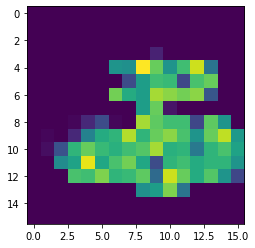

In [25]:
plt.imshow(density)
plt.show()

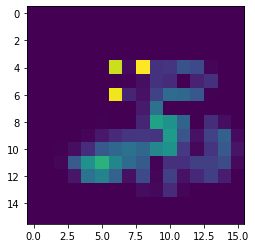

In [26]:
plt.imshow(rawdensity)